In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pickle
import numpy as np
import os

In [3]:
from google.colab import files
uploaded = files.upload()

Saving starwars.txt to starwars.txt


In [4]:
file = open("starwars.txt", "r", encoding = "utf8")

# store file in list
lines = []
for i in file:
    lines.append(i)

# Convert list to string
data = ""
for i in lines:
  data = ' '. join(lines)

#replace unnecessary stuff with space
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '').replace('“','').replace('”','')  #new line, carriage return, unicode character --> replace by space

#remove unnecessary spaces
data = data.split()
data = ' '.join(data)
data[:500]

'Hast du das gehört? Sie haben den Hauptreaktor getroffen. Wir werden bestimmt vernichtet werden. Der reine Wahnsinn! Wir sind verloren. Diesmal gibt es kein Entrinnen für die Prinzessin. Was ist denn das? R2-D2, wo bist du? Endlich. Wo hast du nur gesteckt? Sie kommen direkt auf uns zu. Was jetzt? Sie werden uns in die Kessel-Gewürzminen schicken oder uns verschrotten. Moment mal. Wo willst du hin? Die Pläne vom Todesstern sind nicht im Computer. Was habt ihr mit der Funkübertragung dieser Pläne'

In [5]:
len(data)

119087

In [6]:
import json

tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])

# saving the tokenizer for predict function
pickle.dump(tokenizer, open('token.pkl', 'wb'))

with open( 'token.json' , 'w' ) as file:
    json.dump( tokenizer.word_index , file )

sequence_data = tokenizer.texts_to_sequences([data])[0]
sequence_data[:15]

[76, 9, 6, 126, 4, 22, 18, 737, 367, 8, 52, 296, 326, 52, 7]

In [7]:
len(sequence_data)

19010

In [8]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

3558


In [9]:
sequences = []
sl = 5

for i in range(sl, len(sequence_data)):
    words = sequence_data[i-sl:i+1]
    sequences.append(words)

print("The Length of sequences are: ", len(sequences))
sequences = np.array(sequences)
sequences[:10]

The Length of sequences are:  19005


array([[ 76,   9,   6, 126,   4,  22],
       [  9,   6, 126,   4,  22,  18],
       [  6, 126,   4,  22,  18, 737],
       [126,   4,  22,  18, 737, 367],
       [  4,  22,  18, 737, 367,   8],
       [ 22,  18, 737, 367,   8,  52],
       [ 18, 737, 367,   8,  52, 296],
       [737, 367,   8,  52, 296, 326],
       [367,   8,  52, 296, 326,  52],
       [  8,  52, 296, 326,  52,   7]])

In [10]:
X = []
y = []

for i in sequences:
    X.append(i[0:sl])
    y.append(i[sl])

X = np.array(X)
y = np.array(y)


In [11]:
print("Data: ", X[:10])
print("Response: ", y[:10])


Data:  [[ 76   9   6 126   4]
 [  9   6 126   4  22]
 [  6 126   4  22  18]
 [126   4  22  18 737]
 [  4  22  18 737 367]
 [ 22  18 737 367   8]
 [ 18 737 367   8  52]
 [737 367   8  52 296]
 [367   8  52 296 326]
 [  8  52 296 326  52]]
Response:  [ 22  18 737 367   8  52 296 326  52   7]


In [12]:
y = to_categorical(y, num_classes=vocab_size)
y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [13]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=sl))
model.add(LSTM(1000, return_sequences=True))
model.add(LSTM(1000))
model.add(Dense(1000, activation="relu"))
model.add(Dense(vocab_size, activation="softmax"))


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5, 10)             35580     
                                                                 
 lstm (LSTM)                 (None, 5, 1000)           4044000   
                                                                 
 lstm_1 (LSTM)               (None, 1000)              8004000   
                                                                 
 dense (Dense)               (None, 1000)              1001000   
                                                                 
 dense_1 (Dense)             (None, 3558)              3561558   
                                                                 
Total params: 16646138 (63.50 MB)
Trainable params: 16646138 (63.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


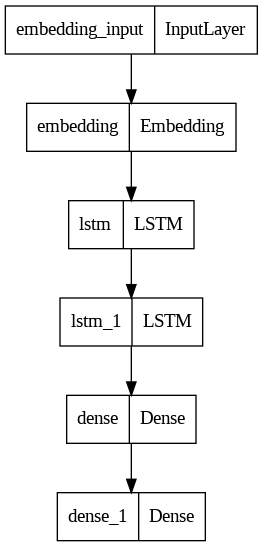

In [15]:
from tensorflow import keras
from keras.utils import plot_model

keras.utils.plot_model(model, to_file='plot.png', show_layer_names=True)


In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("next_words.h5", monitor='loss', verbose=1, save_best_only=True)
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001))
model.fit(X, y, epochs=100, batch_size=64, callbacks=[checkpoint])


Epoch 1/100
295/297 [============================>.] - ETA: 0s - loss: 6.9700
Epoch 1: loss improved from inf to 6.96901, saving model to next_words.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


297/297 [==============================] - 16s 38ms/step - loss: 6.9690
Epoch 2/100
297/297 [==============================] - ETA: 0s - loss: 6.6304
Epoch 2: loss improved from 6.96901 to 6.63042, saving model to next_words.h5
297/297 [==============================] - 6s 20ms/step - loss: 6.6304
Epoch 3/100
294/297 [============================>.] - ETA: 0s - loss: 6.4377
Epoch 3: loss improved from 6.63042 to 6.43586, saving model to next_words.h5
297/297 [==============================] - 6s 19ms/step - loss: 6.4359
Epoch 4/100
295/297 [============================>.] - ETA: 0s - loss: 6.2263
Epoch 4: loss improved from 6.43586 to 6.22498, saving model to next_words.h5
297/297 [==============================] - 6s 19ms/step - loss: 6.2250
Epoch 5/100
297/297 [==============================] - ETA: 0s - loss: 6.0265
Epoch 5: loss improved from 6.22498 to 6.02654, saving model to next_words.h5
297/297 [==============================] - 6s 20ms/step - loss: 6.0265
Epoch 6/100
297/297 

In [17]:
from tensorflow.keras.models import load_model
import numpy as np
import pickle

# Load the model and tokenizer
model = load_model('next_words.h5')
tokenizer = pickle.load(open('token.pkl', 'rb'))

def Predict_Next_Words(model, tokenizer, text):

  sequence = tokenizer.texts_to_sequences([text])
  sequence = np.array(sequence)
  preds = np.argmax(model.predict(sequence))
  predicted_word = ""

  for key, value in tokenizer.word_index.items():
      if value == preds:
          predicted_word = key
          break

  print(predicted_word)
  return predicted_word

In [20]:
while(True):
  text = input("Enter your line: ")

  if text == "0":
      print("Execution completed.....")
      break

  else:
      try:
          text = text.split(" ")
          text = text[-3:]
          print(text)

          Predict_Next_Words(model, tokenizer, text)

      except Exception as e:
        print("Error occurred: ",e)
        continue

Enter your line: Möge die Macht
['Möge', 'die', 'Macht']
1/1 [==============================] - 0s 19ms/step
mit


KeyboardInterrupt: Interrupted by user